<a href="https://colab.research.google.com/github/raihanewubd/CNNwithEvolutionary-algorithms/blob/main/CNNwithEvolutionaryV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

# Transformations for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

In [3]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 47.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
train_dataset[0][0].shape

torch.Size([3, 32, 32])

In [5]:
train_dataset[0][1]

6

In [6]:
print(f"{len(train_dataset)} {type(train_dataset)}")


50000 <class 'torchvision.datasets.cifar.CIFAR10'>


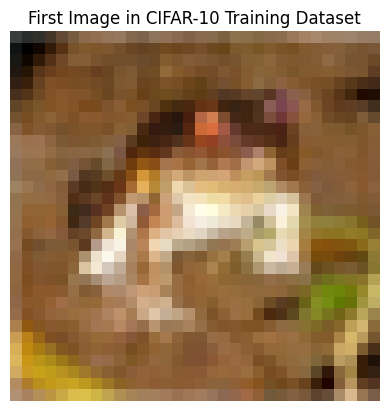

In [7]:
# Get the image tensor
image_tensor = train_dataset[0][0]

# Convert the image tensor to a NumPy array
image_np = image_tensor.numpy()

# Transpose the dimensions to (height, width, channels) for Matplotlib
image_np = np.transpose(image_np, (1, 2, 0))

# Un-normalize the image if you normalized it during preprocessing
# Assuming you normalized to [-1, 1] using transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
image_np = (image_np * 0.5) + 0.5  # Un-normalize to [0, 1]

# Clip values to be in the range [0, 1]
image_np = np.clip(image_np, 0, 1)

# Display the image using Matplotlib
plt.imshow(image_np)
plt.title("First Image in CIFAR-10 Training Dataset")
plt.axis('off')  # Turn off axis ticks and labels
plt.show()

In [8]:
def get_flat_params(model):
    # Get all model parameters as a flattened numpy array
    return np.concatenate([param.data.cpu().numpy().flatten() for param in model.parameters()])

def set_flat_params(model, flat_params):
    # Set model parameters from a flattened numpy array
    idx = 0
    for param in model.parameters():
        param_size = param.numel()
        param.data = torch.tensor(flat_params[idx:idx + param_size].reshape(param.size())).to(param.device)
        idx += param_size


In [9]:
def evaluate_model(model, dataloader, criterion):
    # Calculate loss for a single epoch
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(dataloader)


In [10]:
def differential_evolution(objective_fn, bounds, population_size=10, generations=50, F=0.5, CR=0.7):
    # Initialize population
    population = [np.random.uniform(low, high, size=bounds.shape[0]) for low, high in bounds]
    best_solution = None
    best_score = float('inf')

    for gen in range(generations):
        new_population = []
        for i in range(population_size):
            # Mutation: Generate a candidate solution
            a, b, c = np.random.choice([j for j in range(population_size) if j != i], 3, replace=False)
            mutant = population[a] + F * (population[b] - population[c])
            mutant = np.clip(mutant, bounds[:, 0], bounds[:, 1])  # Ensure bounds

            # Crossover: Combine mutant and current solution
            trial = np.copy(population[i])
            for j in range(bounds.shape[0]):
                if np.random.rand() < CR:
                    trial[j] = mutant[j]

            # Evaluate and select the better solution
            trial_score = objective_fn(trial)
            current_score = objective_fn(population[i])

            if trial_score < current_score:
                new_population.append(trial)
                if trial_score < best_score:
                    best_solution, best_score = trial, trial_score
            else:
                new_population.append(population[i])

        population = new_population
        print(f"Generation {gen+1}/{generations}, Best Score: {best_score}")

    return best_solution


In [12]:
class SimplifiedCNN(nn.Module):
    def __init__(self):
        super(SimplifiedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        dummy_input = torch.randn(1, 3, 32, 32)
        out = self.pool(F.relu(self.conv2(F.relu(self.conv1(dummy_input)))))
        self.feature_size = out.numel()

        self.fc1 = nn.Linear(self.feature_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimplifiedCNN().to(device)
criterion = nn.CrossEntropyLoss()

# Objective function for DE
def objective_function(flat_params):
    set_flat_params(model, flat_params)
    return evaluate_model(model, train_loader, criterion)

# Bounds for parameters
flat_params = get_flat_params(model)
bounds = np.array([(-1, 1) for _ in flat_params])  # Adjust bounds as needed
best_params = differential_evolution(objective_function, bounds, population_size=5, generations=50)
